#### This notebook shows the method to calculate the 

In [1]:
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import scipy.optimize as spopt
from astropy.io import fits
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from astropy.modeling import models, fitting
from astropy import units as u
from astropy.nddata import StdDevUncertainty
from astropy.table import Table
from uncertainties import unumpy
from uncertainties.umath import *
from sklearn.linear_model import LinearRegression
import seaborn as sns
import scipy.stats as sps
from scipy.stats import pearsonr
import pandas as pd
from collections import defaultdict
import ppscore as pps
import pymc as pm
import arviz as az
#%matplotlib notebook

### Load data

In [2]:
# Our sample
DIB_all = pd.read_csv('DIB_result_v2.csv', index_col=0)
DIB_names = [4430, 4501, 4726, 4762, 4964, 5780, 5797, 5849, 6196, 6284, 6379, 6614, 7224, 8620, 9577, 9632, 13176, 15268]

Rv = unumpy.uarray(DIB_all['Rv'], DIB_all['Rv_err'])
Av = unumpy.uarray(DIB_all['Av'], DIB_all['Av_err'])
EBV = Av / Rv
target_names = DIB_all.index

#EW_2175_old = unumpy.uarray(DIB_all['A_2175'], DIB_all['A_err_2175'])
B3 = unumpy.uarray(DIB_all['B3'], DIB_all['B3_err'])
gamma = unumpy.uarray(DIB_all['gamma'], DIB_all['gamma_err'])
EW_2175 = B3 * gamma * np.pi / 2 * EBV

def read_IR_data(file_name):
    data_lines = open('IR_results_cm/' + file_name).readlines()
    EW = np.full(len(data_lines), np.nan)
    EW_err = np.full(len(data_lines), np.nan)
    
    for i, line in enumerate(data_lines):
        parts = line.split()
        if file_name[6:8] == '34':
            EW[i] = float(parts[7])
            EW_err[i] = float(parts[8])
            if EW[i] <= 0:
                EW[i] = 0   # I set the negative carbon values as 0 for now
        else:        
            EW[i] = float(parts[5])
            EW_err[i] = float(parts[6])
    
    return unumpy.uarray(EW, EW_err)

# Define file paths for each dataset
carbon_619_name = 'Carbon619_cm.txt'
carbon_625_name = 'Carbon625_cm.txt'
silicate_name = 'Silicate_cm.txt'
carbon_338_name = 'Carbon34_1_cm.txt'
carbon_342_name = 'Carbon34_2_cm.txt'
carbon_347_name = 'Carbon34_3_cm.txt'
carbon_352_name = 'Carbon34_4_cm.txt'
carbon_329_name = 'Carbon34_5_cm.txt'

# Read each dataset using the function
EW_Carbon_619 = read_IR_data(carbon_619_name)
EW_Carbon_625 = read_IR_data(carbon_625_name)
EW_Silicate = read_IR_data(silicate_name)
EW_Carbon_338 = read_IR_data(carbon_338_name)
EW_Carbon_342 = read_IR_data(carbon_342_name)
EW_Carbon_347 = read_IR_data(carbon_347_name)
EW_Carbon_352 = read_IR_data(carbon_352_name)
EW_Carbon_329 = read_IR_data(carbon_329_name)

### Plot the Pearson correlations between Carbon 6.19 and 18 DIBs

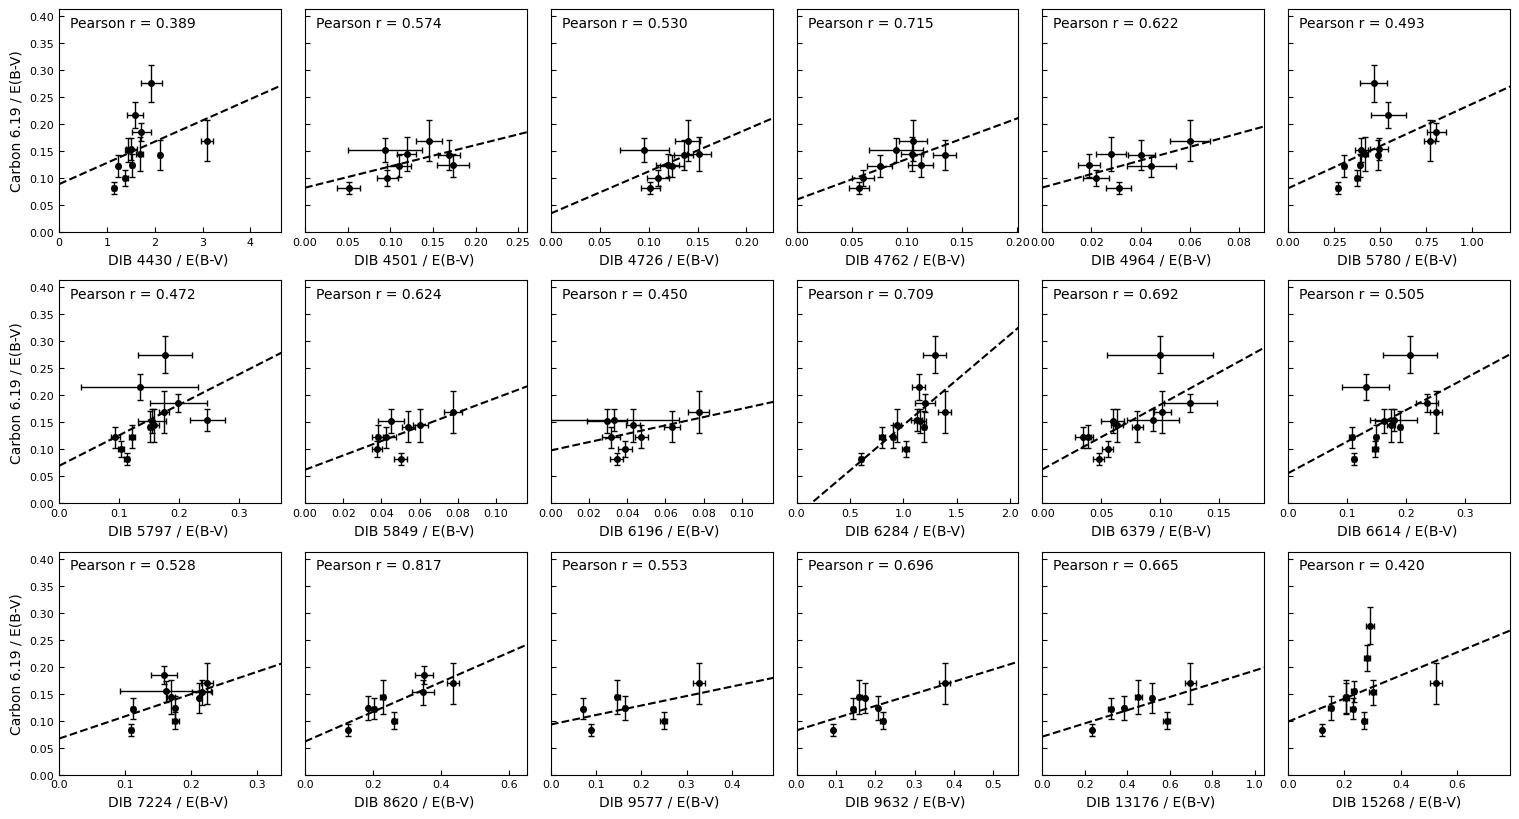

In [8]:
fig, ax = plt.subplots(3, 6, figsize=(15, 8), sharey = True)
plt.subplots_adjust(hspace=0.01, wspace=0.01)
n = 0
for i,j in zip([0,0,0,0,0,0,1,1,1,1,1,1,2,2,2,2,2,2],[0,1,2,3,4,5,0,1,2,3,4,5,0,1,2,3,4,5]): 
    EW = unumpy.uarray(DIB_all['EW_' + str(DIB_names[n])], DIB_all['EW_err_' + str(DIB_names[n])])
    x = EW / EBV
    y = EW_Carbon_619 / EBV 
    
    func = lambda x, a, b: x * a + b
    r2, pcov = spopt.curve_fit(func, unumpy.nominal_values(x), unumpy.nominal_values(y), nan_policy = 'omit')
    ax[i,j].plot(range(10), r2[0] * range(10) + r2[1], '--', color = 'black')  
    
    corr_arr = pd.DataFrame( (unumpy.nominal_values(x), unumpy.nominal_values(y) ) , index=None).T.corr()
    corr = corr_arr[0][1]
    ax[i,j].text(0.05, 0.92, 'Pearson r = ' + '%.3f' % corr, fontsize=10, transform=ax[i,j].transAxes)
    
    ax[i,j].errorbar(unumpy.nominal_values(x), unumpy.nominal_values(y), xerr=unumpy.std_devs(x), yerr=unumpy.std_devs(y), markersize=4,
                 color='black', fmt='o', capsize=2, elinewidth=1, label='This paper')

    ax[i,j].set_xlabel('DIB ' + str(DIB_names[n]) + ' / E(B-V) ', fontsize=10)
    ax[i,0].set_ylabel('Carbon 6.19 / E(B-V)', fontsize=10)
    ax[i,j].set_xlim(0, np.nanmax(unumpy.nominal_values(x)) * 1.5)
    ax[i,j].set_ylim(0, np.nanmax(unumpy.nominal_values(y)) * 1.5)
    ax[i,j].tick_params(axis='both', labelsize=8, direction='in')
    n = n + 1

plt.rcParams["figure.autolayout"] = True
plt.tight_layout(pad=0, h_pad=1, w_pad=None)
plt.show()

### Estimate correlation using Bayesian model and PyMC

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, chol_cov, latent]


Output()

Sampling 4 chains for 200 tune and 1_000 draw iterations (800 + 4_000 draws total) took 134 seconds.


Corr_Carbon6.19_DIB4430 = 0.362+-0.29


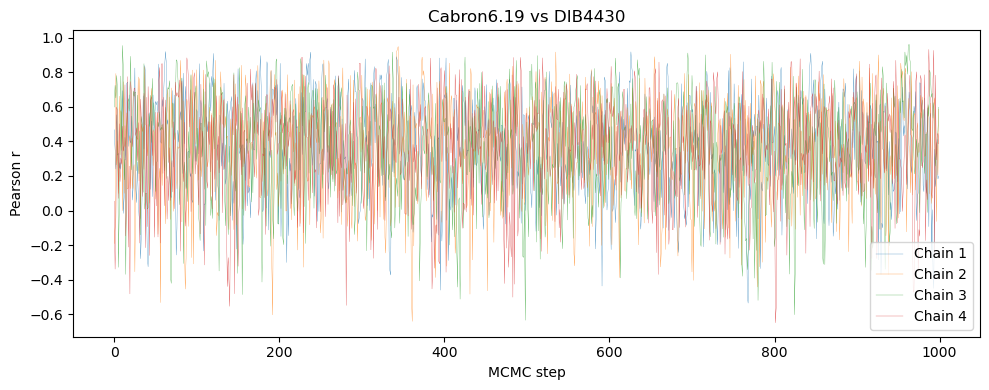

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, chol_cov, latent]


Output()

Sampling 4 chains for 200 tune and 1_000 draw iterations (800 + 4_000 draws total) took 150 seconds.


Corr_Carbon6.19_DIB4501 = 0.426+-0.351


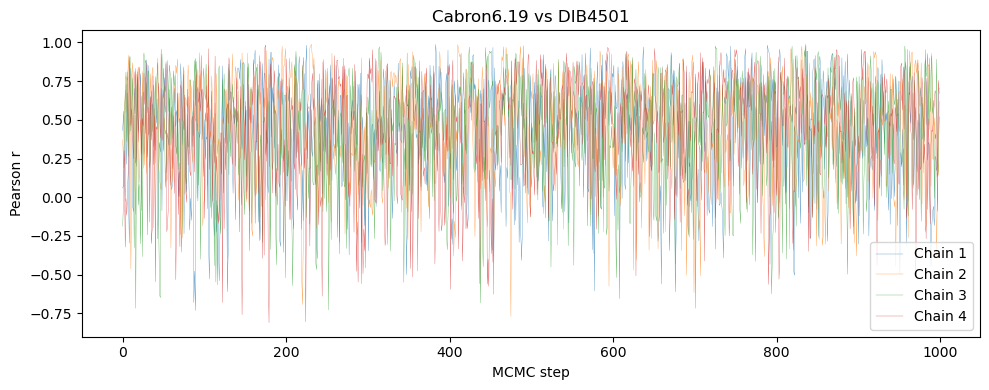

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, chol_cov, latent]


Output()

Sampling 4 chains for 200 tune and 1_000 draw iterations (800 + 4_000 draws total) took 197 seconds.


Corr_Carbon6.19_DIB4726 = 0.353+-0.382


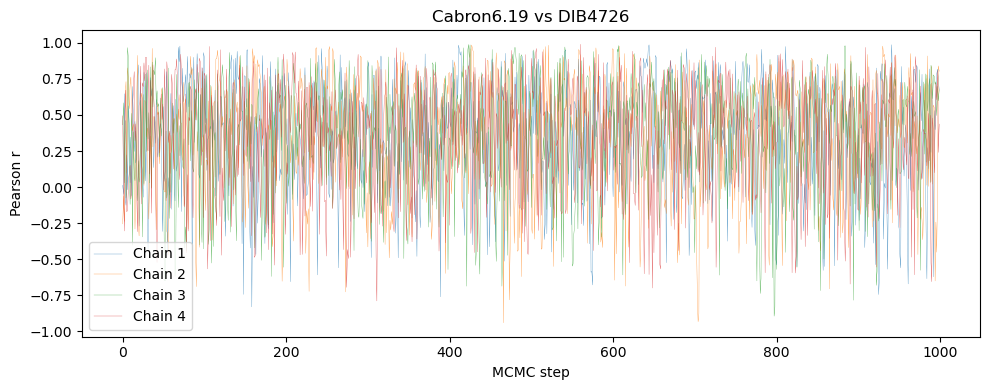

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, chol_cov, latent]


Output()

Sampling 4 chains for 200 tune and 1_000 draw iterations (800 + 4_000 draws total) took 2077 seconds.


Corr_Carbon6.19_DIB4762 = 0.45+-0.341


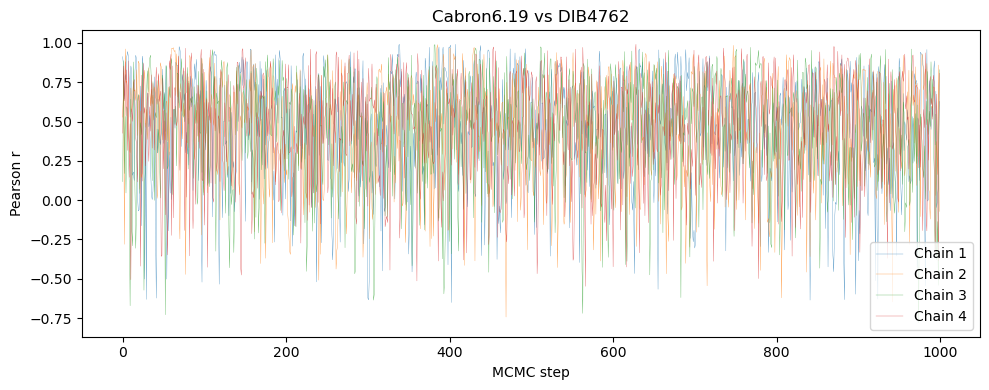

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, chol_cov, latent]


Output()

Sampling 4 chains for 200 tune and 1_000 draw iterations (800 + 4_000 draws total) took 359 seconds.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.


Corr_Carbon6.19_DIB4964 = 0.213+-0.397


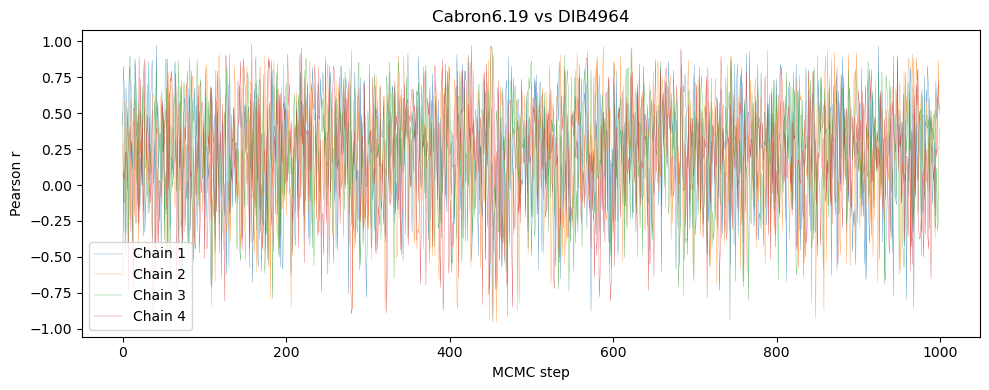

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, chol_cov, latent]


Output()

Sampling 4 chains for 200 tune and 1_000 draw iterations (800 + 4_000 draws total) took 148 seconds.


Corr_Carbon6.19_DIB5780 = 0.493+-0.271


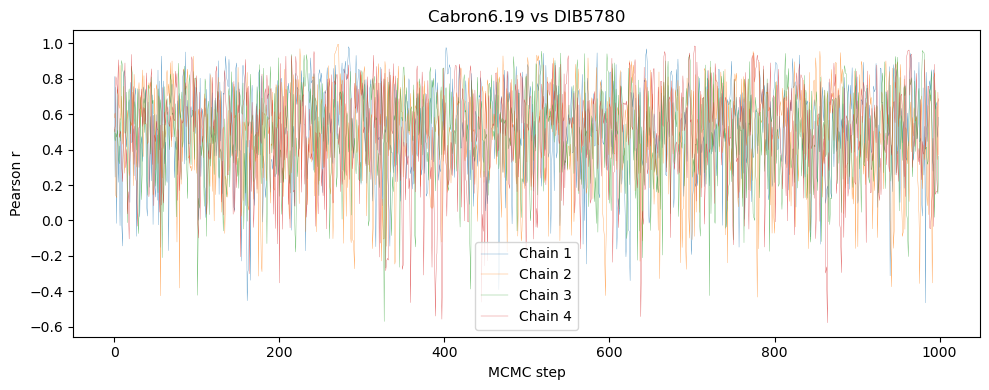

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, chol_cov, latent]


Output()

Sampling 4 chains for 200 tune and 1_000 draw iterations (800 + 4_000 draws total) took 241 seconds.


Corr_Carbon6.19_DIB5797 = 0.53+-0.289


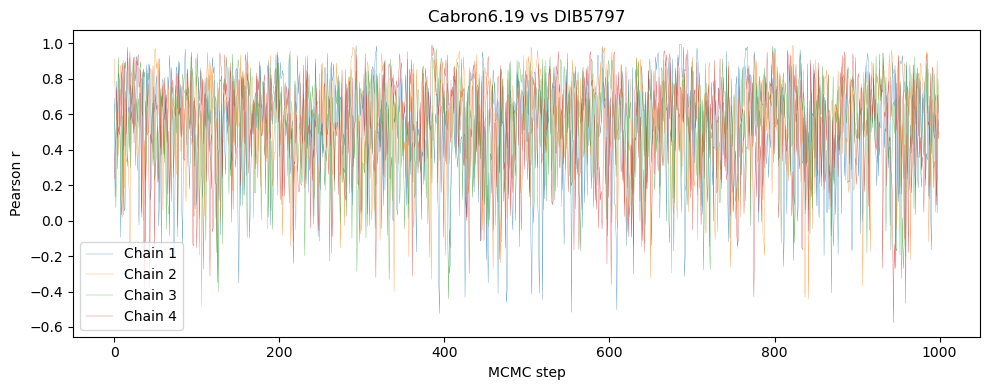

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, chol_cov, latent]


Output()

Sampling 4 chains for 200 tune and 1_000 draw iterations (800 + 4_000 draws total) took 378 seconds.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.


Corr_Carbon6.19_DIB5849 = 0.235+-0.377


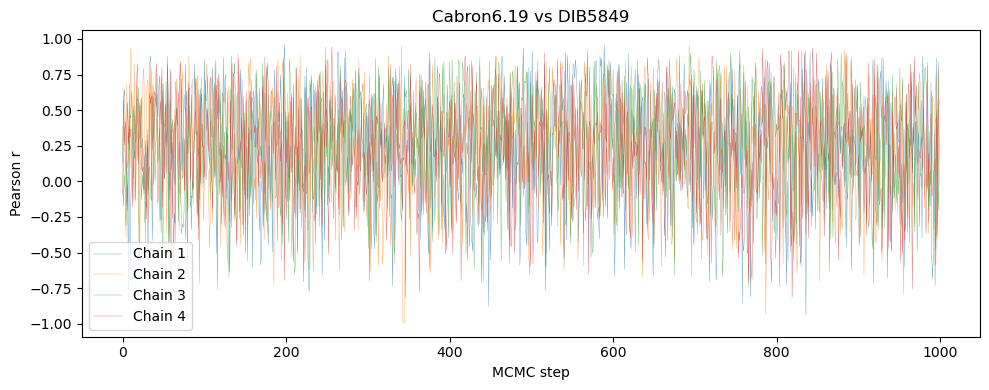

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, chol_cov, latent]


Output()

Sampling 4 chains for 200 tune and 1_000 draw iterations (800 + 4_000 draws total) took 339 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


Corr_Carbon6.19_DIB6196 = 0.309+-0.371


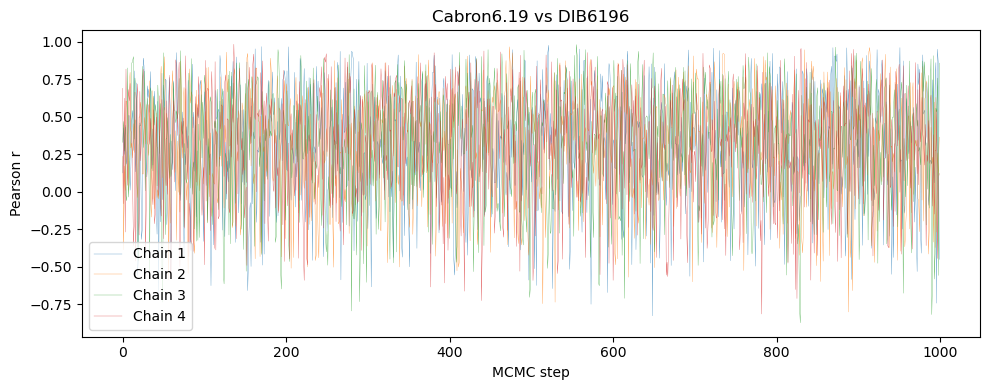

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, chol_cov, latent]


Output()

Sampling 4 chains for 200 tune and 1_000 draw iterations (800 + 4_000 draws total) took 126 seconds.


Corr_Carbon6.19_DIB6284 = 0.611+-0.231


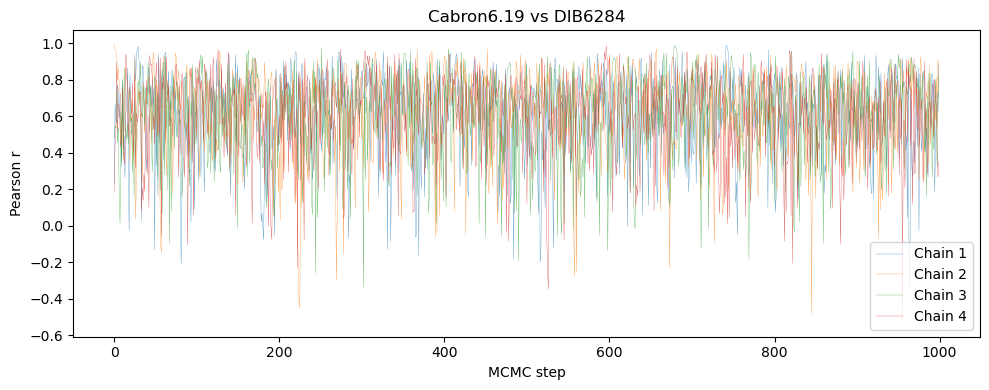

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, chol_cov, latent]


Output()

Sampling 4 chains for 200 tune and 1_000 draw iterations (800 + 4_000 draws total) took 328 seconds.


Corr_Carbon6.19_DIB6379 = 0.569+-0.27


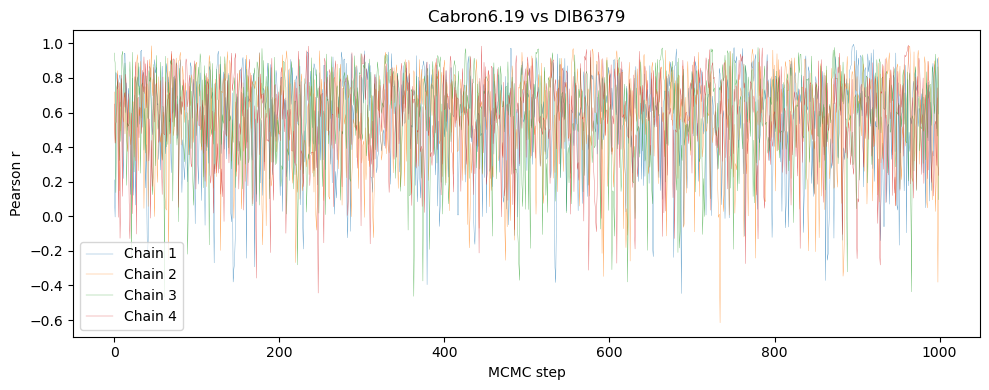

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, chol_cov, latent]


Output()

Sampling 4 chains for 200 tune and 1_000 draw iterations (800 + 4_000 draws total) took 252 seconds.


Corr_Carbon6.19_DIB6614 = 0.517+-0.283


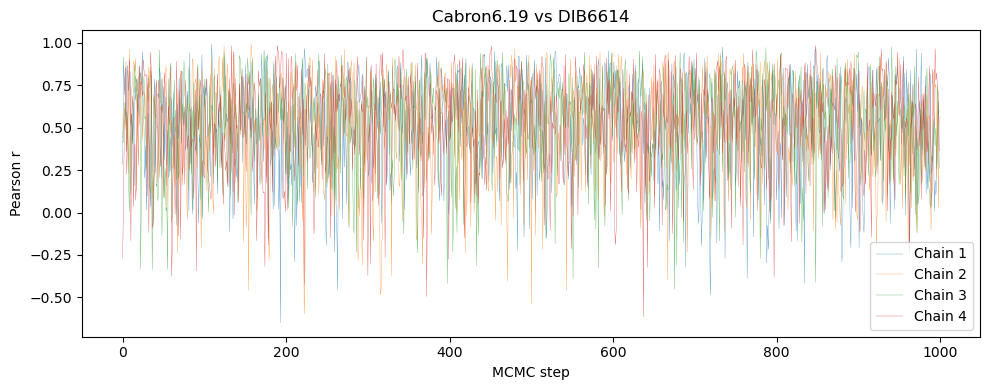

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, chol_cov, latent]


Output()

Sampling 4 chains for 200 tune and 1_000 draw iterations (800 + 4_000 draws total) took 267 seconds.


Corr_Carbon6.19_DIB7224 = 0.353+-0.32


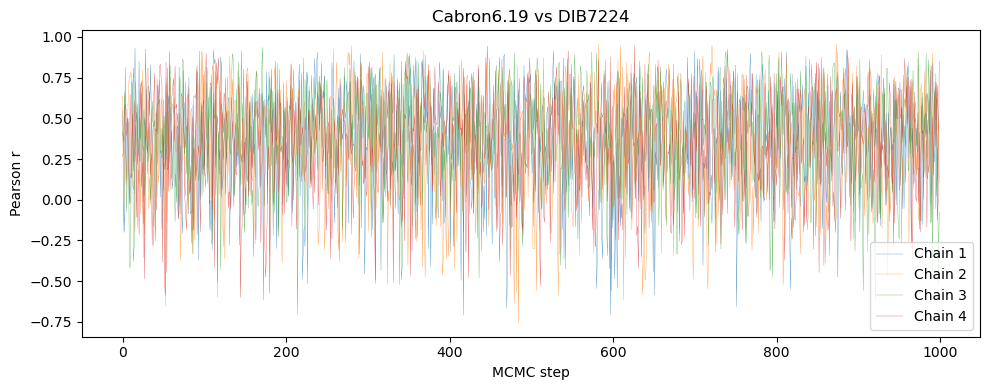

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, chol_cov, latent]


Output()

Sampling 4 chains for 200 tune and 1_000 draw iterations (800 + 4_000 draws total) took 222 seconds.


Corr_Carbon6.19_DIB8620 = 0.525+-0.313


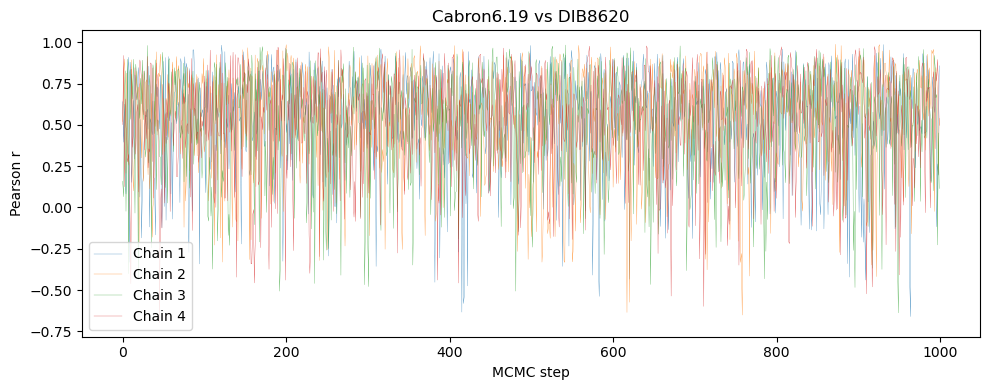

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, chol_cov, latent]


Output()

Sampling 4 chains for 200 tune and 1_000 draw iterations (800 + 4_000 draws total) took 302 seconds.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


Corr_Carbon6.19_DIB9577 = 0.181+-0.398


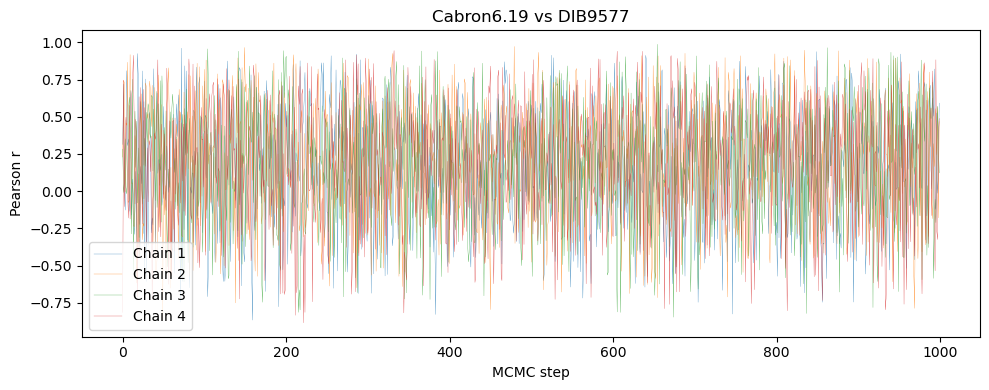

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, chol_cov, latent]


Output()

Sampling 4 chains for 200 tune and 1_000 draw iterations (800 + 4_000 draws total) took 265 seconds.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


Corr_Carbon6.19_DIB9632 = 0.323+-0.381


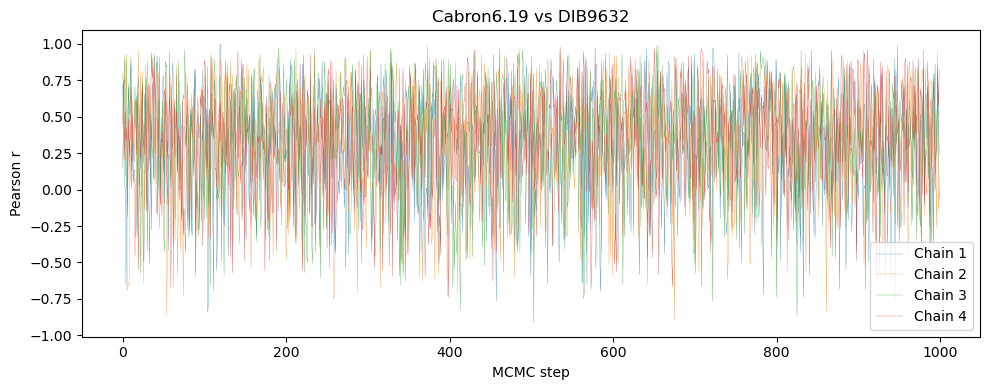

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, chol_cov, latent]


Output()

Sampling 4 chains for 200 tune and 1_000 draw iterations (800 + 4_000 draws total) took 232 seconds.
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Corr_Carbon6.19_DIB13176 = 0.275+-0.37


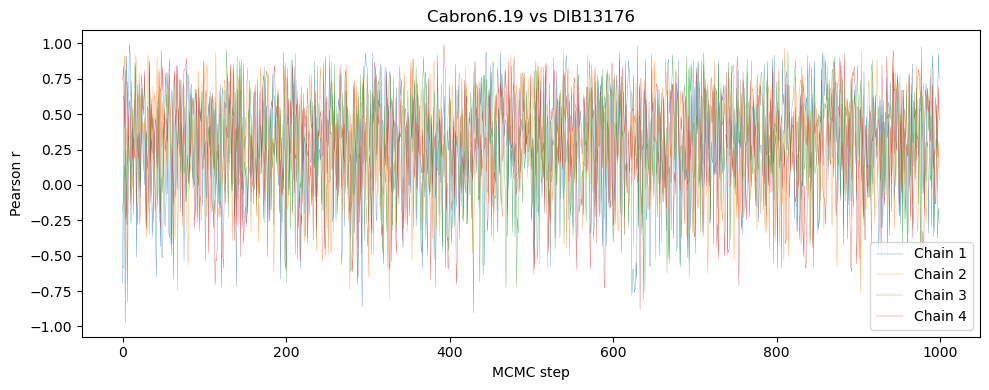

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, chol_cov, latent]


Output()

Sampling 4 chains for 200 tune and 1_000 draw iterations (800 + 4_000 draws total) took 217 seconds.


Corr_Carbon6.19_DIB15268 = 0.359+-0.288


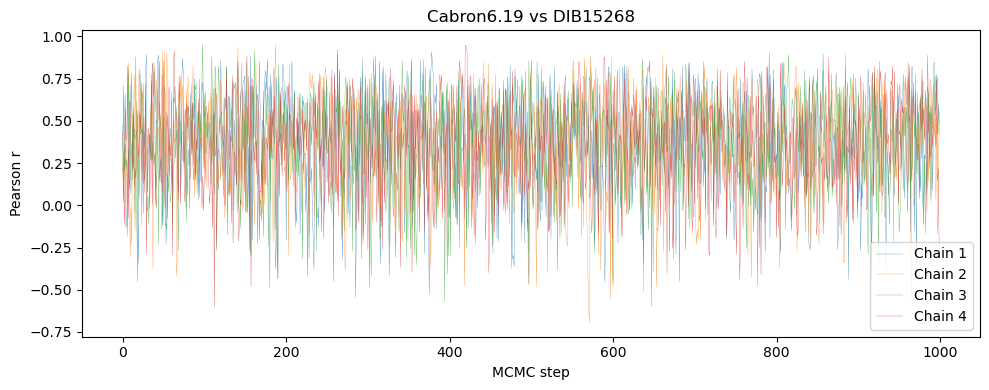

In [ ]:
y = EW_Carbon_619 / EBV 

for (i, DIB_name) in enumerate(DIB_names):
    x = unumpy.uarray(DIB_all['EW_' + str(DIB_name)], DIB_all['EW_err_' + str(DIB_name)]) / EBV

    x_nom = unumpy.nominal_values(x)
    y_nom = unumpy.nominal_values(y)
    x_err = unumpy.std_devs(x)
    y_err = unumpy.std_devs(y)
        
    mask = np.isfinite(x_nom) & np.isfinite(y_nom) & np.isfinite(x_err) & np.isfinite(y_err)
    x_nom, y_nom = x_nom[mask], y_nom[mask]
    x_err, y_err = x_err[mask], y_err[mask]
    x_err = np.clip(x_err, 1e-6, np.inf)
    y_err = np.clip(y_err, 1e-6, np.inf)
    n_data = len(x_nom)

    with pm.Model() as model:
        # Prior for the mean of latent variables
        mu = pm.Normal("mu", mu=0, sigma=1, shape=2)

        # LKJ prior for covariance matrix with correlation
        sd_dist = pm.HalfNormal.dist(sigma=1.0)
        chol, corr, sigmas = pm.LKJCholeskyCov('chol_cov', eta=2, n=2, sd_dist=sd_dist, compute_corr=True)

        # Latent true variables with correlation
        latent = pm.MvNormal("latent", mu=mu, chol=chol, shape=(n_data, 2))

        # Likelihood for observations with measurement error
        pm.Normal("x_obs", mu=latent[:, 0], sigma=x_err, observed=x_nom)
        pm.Normal("y_obs", mu=latent[:, 1], sigma=y_err, observed=y_nom)

        # Sample posterior
        trace = pm.sample(1000, tune=200, target_accept=0.99, chains=4, progressbar=True)

        # Extract posterior mean correlation
        rho_post = trace.posterior['chol_cov_corr'].sel(chol_cov_corr_dim_0=0, chol_cov_corr_dim_1=1)
        rho_mean = rho_post.mean().item()
        rho_std = rho_post.std().item()

        aprint(z.summary(trace, var_names=['chol_cov_corr'], kind='all', round_to=2))
        
        print('Corr_Carbon6.19_DIB' + str(DIB_name) + ' = ' + str(round(rho_mean,3)) + '+-' + str(round(rho_std,3)))

        fig, ax = plt.subplots(figsize=(10, 4))
        for chain in rho_post.chain:
            ax.plot(rho_post.sel(chain=chain), label=f"Chain {int(chain)+1}", lw=0.2)
        ax.set_title('Cabron6.19 vs DIB' + str(DIB_name))
        ax.set_xlabel("MCMC step")
        ax.set_ylabel("Pearson r")
        ax.legend()
        plt.tight_layout()
        plt.show()

### Predictive Power Score 

In [13]:
y = EW_Carbon_619 / EBV 

for (i, DIB_name) in enumerate(DIB_names):    
    x = unumpy.uarray(DIB_all['EW_' + str(DIB_name)], DIB_all['EW_err_' + str(DIB_name)]) / EBV

    df_pps = pd.DataFrame({'x': unumpy.nominal_values(x), 'y': unumpy.nominal_values(y)}).dropna()
    score = pps.score(df_pps, x='y', y='x')['ppscore']
    print('PPS_Carbon6.19_DIB' + str(DIB_name) + ' = ' + str(score))

PPS_Carbon6.19_DIB4430 = 0
PPS_Carbon6.19_DIB4501 = 0
PPS_Carbon6.19_DIB4726 = 0
PPS_Carbon6.19_DIB4762 = 0.02644235119586058
PPS_Carbon6.19_DIB4964 = 0
PPS_Carbon6.19_DIB5780 = 0.10298968401379027
PPS_Carbon6.19_DIB5797 = 0.02464076299135265
PPS_Carbon6.19_DIB5849 = 0
PPS_Carbon6.19_DIB6196 = 0
PPS_Carbon6.19_DIB6284 = 0
PPS_Carbon6.19_DIB6379 = 0.3477477121370671
PPS_Carbon6.19_DIB6614 = 0
PPS_Carbon6.19_DIB7224 = 0
PPS_Carbon6.19_DIB8620 = 0
PPS_Carbon6.19_DIB9577 = 0
PPS_Carbon6.19_DIB9632 = 0
PPS_Carbon6.19_DIB13176 = 0
PPS_Carbon6.19_DIB15268 = 0
